In [104]:
!pip install numpy
!pip install pandas
!pip install openpyxl
!pip install nltk
!pip install sklearn
!pip install fasttext
!pip install wordcloud
!pip install -U sentence-transformers

     |████████████████████████████████| 160 kB 264 kB/s eta 0:00:01


In [105]:
import os
import numpy as np
import nltk
import pandas as pd
import json
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk import word_tokenize
import string
import json
import unidecode 
import re 

import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/kian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## --------------------------- Reading data ---------------------------

In [130]:
dfs = []
for file in os.listdir("./Excels"):
    df = pd.read_excel(os.path.join("./Excels", file))
    dfs.append(df)
    print(file, end=": ")
    print(df.shape)
df = pd.concat(dfs)

science.xlsx: (2080, 19)
nvidia.xlsx: (2010, 19)
Meta.xlsx: (1644, 19)
Google.xlsx: (2051, 19)
robots.xlsx: (1982, 19)
Twitter.xlsx: (1616, 19)
metaverse.xlsx: (1553, 19)
Microsoft.xlsx: (2080, 19)
facebook.xlsx: (2027, 19)
spaceX.xlsx: (2010, 19)
WWDC.xlsx: (2080, 19)
tech.xlsx: (2076, 19)
instagram.xlsx: (1949, 19)
Amazon.xlsx: (2078, 19)
Apple.xlsx: (2031, 19)
Tesla.xlsx: (2004, 19)


In [131]:
df.columns, df.shape

(Index(['Tweet Id', 'Text', 'Name', 'Screen Name', 'UTC', 'Created At',
        'Favorites', 'Retweets', 'Language', 'Client', 'Tweet Type', 'URLs',
        'Hashtags', 'Mentions', 'Media Type', 'Media URLs', 'Unnamed: 16',
        'Unnamed: 17', 'Unnamed: 18'],
       dtype='object'),
 (31271, 19))

In [133]:
df = df[df['Language'] == 'en']
df.reset_index(drop=True, inplace=True)
df.drop_duplicates(subset="Text", keep='first', inplace=True, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12665 entries, 0 to 12664
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Tweet Id     12665 non-null  int64 
 1   Text         12665 non-null  object
 2   Name         12665 non-null  object
 3   Screen Name  12665 non-null  object
 4   UTC          12665 non-null  object
 5   Created At   12665 non-null  object
 6   Favorites    12665 non-null  int64 
 7   Retweets     12665 non-null  int64 
 8   Language     12665 non-null  object
 9   Client       12665 non-null  object
 10  Tweet Type   12665 non-null  object
 11  URLs         7151 non-null   object
 12  Hashtags     12665 non-null  int64 
 13  Mentions     12665 non-null  int64 
 14  Media Type   5619 non-null   object
 15  Media URLs   5619 non-null   object
 16  Unnamed: 16  598 non-null    object
 17  Unnamed: 17  379 non-null    object
 18  Unnamed: 18  244 non-null    object
dtypes: int64(5), object(14)
m

## --------------------------- Preprocessing data ---------------------------

In [134]:
class Preprocessor:
    def __init__(self):
    
        contraction_map_path = 'HW4/contraction_map.json'
        # contraction_map_path = '/content/gdrive/MyDrive/MIR-HW4/contraction_map.json'
        with open(contraction_map_path) as f:
            self.contraction_map = json.load(f)
        
        nltk.download('stopwords')
        self.stoplist = stopwords.words('english') 
        self.stoplist = set(self.stoplist)
        
        self.w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
        
    def remove_newlines_tabs(self, text):
        formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ')
        formatted_text = formatted_text.replace('\\', ' ').replace('. com', '.com')
        return formatted_text

    def remove_mentions_hashtagSigns(self, text):
        tokenized = text.split(" ")
        formatted_text = ""
        for w in tokenized:
            if not w:
                continue
            if w[0] == "@":
                continue
            if w[0] == "#":
                formatted_text += f"{w[1:]} "
            else:
                formatted_text += f"{w} "

        return formatted_text.strip()

    def strip_html_tags(self, text):
        soup = BeautifulSoup(text, "html.parser")
        stripped_text = soup.get_text(separator=" ")
        return stripped_text

    def remove_punctuations(self, text):
        formatted = ""
        for char in text:
            if char in string.punctuation:
                continue
            else:
                formatted += char
        return formatted

    def remove_links(self, text):
        remove_https = re.sub(r'http\S+', '', text)
        remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
        return remove_com

    def remove_whitespace(self, text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        return text

    def accented_characters_removal(self, text):
        # Remove accented characters from text using unidecode.
        # Unidecode() - It takes unicode data & tries to represent it to ASCII characters. 
        text = unidecode.unidecode(text)
        return text

    def lower_casing_text(self, text):
        return text.lower()

    def reducing_incorrect_character_repeatation(self, text):
        Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)

        # Limiting all the  repeatation to two characters.
        Formatted_text = Pattern_alpha.sub(r"\1\1", text) 

        # Pattern matching for all the punctuations that can occur
        Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')

        # Limiting punctuations in previously formatted string to only one.
        Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)

        # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
        Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
        return Final_Formatted


    def expand_contractions(self, text):
        contraction_mapping = self.contraction_map
        list_Of_tokens = text.split(' ')
        for Word in list_Of_tokens: 
             if Word in contraction_mapping: 
                list_Of_tokens = [item.replace(Word, contraction_mapping[Word]) for item in list_Of_tokens]

        String_Of_tokens = ' '.join(str(e) for e in list_Of_tokens) 
        return String_Of_tokens

    def removing_special_characters(self, text):
        formatted_text = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', text) 
        return formatted_text

    def remove_numbers(self, text):
        formatted_text = re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ', text)
        return formatted_text

    def removing_stopwords(self, text):
        text = repr(text)
        No_StopWords = [word for word in word_tokenize(text) if word.lower() not in self.stoplist]
        words_string = ' '.join(No_StopWords)    
        return words_string

    def spelling_correction(self, text):
        spell = Speller(lang='en')
        Corrected_text = spell(text)
        return Corrected_text
    
    def cleaning_and_preprocessing(self, tweet,
                              remove_newlines_=True,
                              remove_mentions_hashtagSigns_=True,
                              strip_html_tags_=True,
                              remove_punctuations_=True,
                              remove_links_=True,
                              remove_whitespace_=True,
                              accented_characters_removal_=True,
                              lower_casing_text_=True,
                              reducing_incorrect_character_repeatation_=True,
                              expand_contractions_=True,
                              remove_numbers_=True,
                              removing_stopwords_=True,
                              spelling_correction_=False):
    
        """
        input: a single text (e.g., a tweet or a sentence with type string).
        output: a single text (e.g., a tweet or a sentence with type string) which is clean:)
        """

        ## Cleaning
        text = tweet
        if remove_newlines_:
            text = self.remove_newlines_tabs(text)
        if remove_mentions_hashtagSigns_:
            text = self.remove_mentions_hashtagSigns(text)
        if strip_html_tags_:
            text = self.strip_html_tags(text)
        if remove_punctuations_:
            text = self.remove_punctuations(text)
        if remove_links_:
            text = self.remove_links(text)
        if remove_whitespace_:
            text = self.remove_whitespace(text)
        if  accented_characters_removal_:   
            text = self.accented_characters_removal(text)
        if lower_casing_text_:
            text = self.lower_casing_text(text)
        if reducing_incorrect_character_repeatation_:
            text = self.reducing_incorrect_character_repeatation(text)
        if expand_contractions_:
            text = self.expand_contractions(text)
        if remove_numbers_:
            text = self.remove_numbers(text)

        ## preprocessing
        if removing_stopwords_:
            text = self.removing_stopwords(text)
        if spelling_correction_:
            text = self.spelling_correction(text)
        return text

    def clean_data(self, df):
        """
        gets whole df as input.
        returns df with new column called cleaned tweets.
        """
        cleaned_tweets = []
        for tweet in tqdm(df.Text):
            cleaned_tweet = self.cleaning_and_preprocessing(tweet)
            cleaned_tweets.append(cleaned_tweet)

        df["cleaned_tweets"] = cleaned_tweets
        return df
    
    def lemmatize_data(self, df):
        """
        gets whole df as input.
        returns df with new column called lemmatized tweets.
        """
        lemmatized_tweets = []
        for tweet in tqdm(df.cleaned_tweets):
            lemma = [self.lemmatizer.lemmatize(w,'v') for w in self.w_tokenizer.tokenize(tweet)]
            lemma = ' '.join(lemma)
            lemmatized_tweets.append(lemma)

        df["lemmatized_tweets"] = lemmatized_tweets
        return df
    
    def tokenize_data(self, df):
        pattern = r'''(?x)          # set flag to allow verbose regexps
                (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
              | \w+(?:-\w+)*        # words with optional internal hyphens
              | \$?\d+(?:\.\d+)?%?\s?  # currency and percentages, e.g. $12.40, 82%
              | \.\.\.              # ellipsis
              | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
            '''

        pattern = re.compile(pattern)
        nltk_tokenized_tweets = [nltk.regexp_tokenize(tweet, pattern)[1:-1] for tweet in df.lemmatized_tweets]
        df['Text_words'] = nltk_tokenized_tweets
        return df
    
    def perform_clean_lemmatize_tokenize(self, df):
        df = self.clean_data(df)
        df = self.lemmatize_data(df)
        df = self.tokenize_data(df)
        return df

In [135]:
preprocessor = Preprocessor()
df = preprocessor.perform_clean_lemmatize_tokenize(df)

[nltk_data] Downloading package stopwords to /Users/kian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12665/12665 [00:01<00:00, 12496.40it/s]


In [136]:
df.head()

,Tweet Id,Text,Name,Screen Name,UTC,Created At,Favorites,Retweets,Language,Client,...,Hashtags,Mentions,Media Type,Media URLs,Unnamed: 16,Unnamed: 17,Unnamed: 18,cleaned_tweets,lemmatized_tweets,Text_words
0,1541760993121804288,RT @inddais : #inddais is as simple as rocket ...,a happiness seeker.,coucane,2022-06-28T12:30:39.000Z,Tue Jun 28 12:30:39 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/android"" ...",...,2,0,video,https://video.twimg.com/ext_tw_video/153998544...,NaN,NaN,NaN,'rt inddais simple rocket science buy seed har...,'rt inddais simple rocket science buy seed har...,"[rt, inddais, simple, rocket, science, buy, se..."
1,1541760992497000453,@ABC How about not leaving pets and kids in th...,p,therealphattyd,2022-06-28T12:30:39.000Z,Tue Jun 28 12:30:39 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/iphone"" r...",...,0,1,NaN,NaN,NaN,NaN,NaN,'how leaving pets kids car start rocket science ','how leave pet kid car start rocket science ',"[how, leave, pet, kid, car, start, rocket, sci..."
2,1541760990634803202,RT @_demola_ : Science students how far🌚\n\nWh...,onobaby,vibequeen01,2022-06-28T12:30:39.000Z,Tue Jun 28 12:30:39 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/android"" ...",...,0,0,photo,https://pbs.twimg.com/media/FWUj-FnXkAENk1X.jpg,NaN,NaN,NaN,'rt science students far happen litmus paper a...,'rt science students far happen litmus paper a...,"[rt, science, students, far, happen, litmus, p..."
3,1541760984754405376,"RT @DayLabUAB : Wow, congratulations to @DrVic...",Anupam Agarwal,anupamuab,2022-06-28T12:30:37.000Z,Tue Jun 28 12:30:37 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/iphone"" r...",...,0,1,NaN,NaN,NaN,NaN,NaN,'rt wow congratulations new position president...,'rt wow congratulations new position president...,"[rt, wow, congratulations, new, position, pres..."
4,1541760982934237184,RT @mdhn_anbu : Its obvious that studying hist...,Anusha,AnsaMdhn,2022-06-28T12:30:37.000Z,Tue Jun 28 12:30:37 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/android"" ...",...,6,0,NaN,NaN,NaN,NaN,NaN,'rt obvious studying history philosophy much b...,'rt obvious study history philosophy much bett...,"[rt, obvious, study, history, philosophy, much..."


In [137]:
df['Text_words'].explode().value_counts().reset_index().head(30)

,index,Text_words
0,rt,4033
1,wwdc,1700
2,apple,1651
3,tesla,1634
4,tech,1550
5,nvidia,1214
6,metaverse,1123
7,spacex,1117
8,science,1097
9,instagram,1090


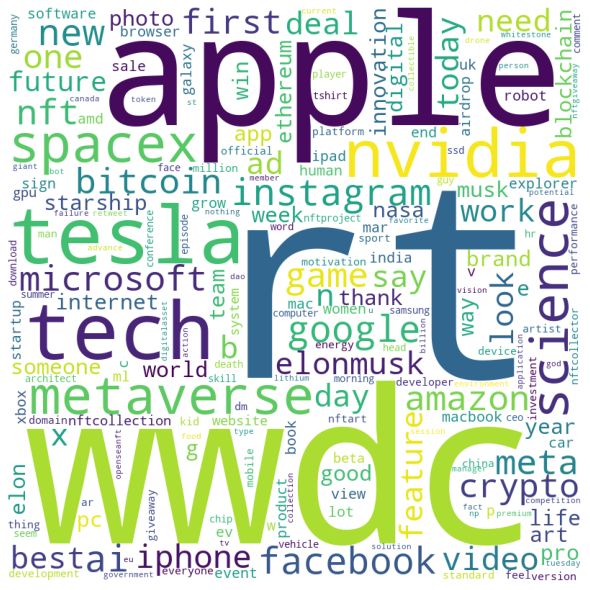

In [138]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = " ".join(set(df['Text_words'].explode()) - {np.nan})
all_words = " ".join(df['Text_words'].explode().value_counts().reset_index()['index'])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [139]:
nltk.FreqDist(df['Text_words'].explode()).most_common(20)

[('rt', 4033),
 ('wwdc', 1700),
 ('apple', 1651),
 ('tesla', 1634),
 ('tech', 1550),
 ('nvidia', 1214),
 ('metaverse', 1123),
 ('spacex', 1117),
 ('science', 1097),
 ('instagram', 1090),
 ('`', 1082),
 ('twitter', 1082),
 ('new', 1067),
 ('facebook', 1059),
 ('robots', 968),
 ('google', 952),
 ("'", 934),
 ('ai', 919),
 ('microsoft', 912),
 ('meta', 885)]

## TF-IDF Search ---------------------------

In [140]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer

class TFIDFSearch:
    def __init__(self):
        self.vocabulary = list(set(df['Text_words'].explode()) - {np.nan})

        self.tfidf = TfidfVectorizer(vocabulary=self.vocabulary)
        self.tfidf_tran=self.tfidf.fit_transform(df['Text_words'].apply(lambda x: ' '.join(x)))

    def get_vector(self, tokens):
        result = np.zeros((len(self.vocabulary)))
        x= self.tfidf.transform(tokens)
        for token in tokens:
            try:
                ind = self.vocabulary.index(token)
                result[ind]  = x[0, self.tfidf.vocabulary_[token]]
            except Exception as e:
                print(e)
                pass
        return result

    @staticmethod
    def cosine_sim(a, b):
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        if norm_a == 0 or norm_b == 0:
            return 0
        cos_sim = np.dot(a, b)/(norm_a*norm_b)
        return cos_sim

    def search(self, k, query):
        tokens = text_to_words(query)
        print(tokens)
        q_df = pd.DataFrame(columns=['q_clean'])
        q_df.loc[0, 'q_clean'] = tokens

        d_cosines = []

        query_vector = self.get_vector(tokens)
        print(sum(query_vector))
        for d in self.tfidf_tran.A:
            d_cosines.append(self.cosine_sim(query_vector, d))

        out = np.array(d_cosines).argsort()[-k:][::-1]
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])
            a.loc[i, 'Score'] = d_cosines[int(index)]
        return a

In [141]:
model = TFIDFSearch()
results = model.search(10, "Elon musk")
results

['elon', 'musk']
1.0


,index,text,words,Score
0,7114,what if Gerald Cotten is Elon Musk (:)\n@elonm...,"['what', 'gerald', 'cotten', 'elon', 'musk', '...",0.628153
1,12610,@elonmusk @elonamuskjet @ElonMuskNewsOrg @Tesl...,"['tesla', 'elon', 'spacex', 'tesla', 'elonmusk']",0.505764
2,7296,Elon Musk replied to @Rainmaker1973 #SpaceX ht...,"['elon', 'musk', 'reply', 'spacex']",0.488420
3,7584,Elon Musk replied to @SpaceX #SpaceX https://t...,"['elon', 'musk', 'reply', 'spacex']",0.488420
4,7545,Elon Musk replied to @Erdayastronaut #SpaceX h...,"['elon', 'musk', 'reply', 'spacex']",0.488420
5,7554,Elon Musk replied to @elonmusk #SpaceX https:/...,"['elon', 'musk', 'reply', 'spacex']",0.488420
6,7559,Elon Musk replied to @SirineAti #SpaceX https:...,"['elon', 'musk', 'reply', 'spacex']",0.488420
7,7573,Elon Musk replied to @DJSnM #SpaceX https://t....,"['elon', 'musk', 'reply', 'spacex']",0.488420
8,7478,RT @EveryElonReply : Elon Musk replied to @Erd...,"['rt', 'elon', 'musk', 'reply', 'spacex']",0.478497
9,7537,RT @EveryElonReply : Elon Musk replied to @elo...,"['rt', 'elon', 'musk', 'reply', 'spacex']",0.478497


In [142]:
for i, res in enumerate(results.text):
    print(f"{i}: ")
    print(res, end="\n\n")

0: 
what if Gerald Cotten is Elon Musk (:)
@elonmusk  #Elon Musk #Elon #Tesla #SpaceX

1: 
@elonmusk @elonamuskjet @ElonMuskNewsOrg @Tesla @teslacn @teslaownersSV @SpaceX @SpaceXStarlink @spacex360 #Tesla Elon SpaceX #Tesla #ElonMusk https://t.co/6oNPBUrppo

2: 
Elon Musk replied to @Rainmaker1973 #SpaceX https://t.co/88DZXBJbB0

3: 
Elon Musk replied to @SpaceX #SpaceX https://t.co/YxsXjwMbnT

4: 
Elon Musk replied to @Erdayastronaut #SpaceX https://t.co/af0kEn5tuX

5: 
Elon Musk replied to @elonmusk #SpaceX https://t.co/WZlfbpp9VL

6: 
Elon Musk replied to @SirineAti #SpaceX https://t.co/FQhsBJNsiV

7: 
Elon Musk replied to @DJSnM #SpaceX https://t.co/edsj1uorGp

8: 
RT @EveryElonReply : Elon Musk replied to @Erdayastronaut #SpaceX https://t.co/af0kEn5tuX

9: 
RT @EveryElonReply : Elon Musk replied to @elonmusk #SpaceX https://t.co/WZlfbpp9VL



## Boolean Search ---------------------------

In [143]:
class BooleanSearch:
    def __init__(self):
        self.vocabulary = list(set(df['Text_words'].explode()) - {np.nan})
        self.vocabulary_index = {word: idx for idx, word in enumerate(self.vocabulary)}

        self.mat = np.zeros((len(df), len(self.vocabulary)), )

        for index, row in df.iterrows():
            for token in row['Text_words']:
                self.mat[index][self.vocabulary_index[token]] = 1


    def search(self, k, query):
        #print("Cosine Similarity")
        tokens = text_to_words(query)
        query_vector = []
        for token in tokens:
            if token in self.vocabulary_index:
                query_vector.append(self.vocabulary_index[token])
        out = []
        for index, vec in enumerate(self.mat):
            flag = True
            for token_index in query_vector:
                if vec[token_index] == 0:
                    flag = False
                    break
            if flag:
                out.append(index)
            if len(out) == k:
                break
        print(out)
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])

        return a

In [144]:
model = BooleanSearch()
model.search(10, "Elon Musk")

[4999, 5122, 5440, 6471, 7114, 7142, 7152, 7153, 7178, 7223]


,index,text,words
0,4999,RT @FreeElonNow : You can’t put a price on fre...,"['rt', 'put', 'price', 'free', 'speech', 'unle..."
1,5122,"When @elonmusk starts running his mouff, y’all...","['when', 'start', 'run', 'mouff', 'need', 'rem..."
2,5440,Elon Musk votes for Mayra Flores in Texas part...,"['elon', 'musk', 'vote', 'mayra', 'flores', 't..."
3,6471,"Sorry Twitter , i mean elon musk #facebook htt...","['sorry', 'twitter', 'mean', 'elon', 'musk', '..."
4,7114,what if Gerald Cotten is Elon Musk (:)\n@elonm...,"['what', 'gerald', 'cotten', 'elon', 'musk', '..."
5,7142,How China could kill Space X.\nSpace X's space...,"['how', 'china', 'could', 'kill', 'space', 'x'..."
6,7152,RT @TweakTown : Elon Musk says @SpaceX's Stars...,"['rt', 'elon', 'musk', 'say', 'starship', 'roc..."
7,7153,Elon Musk says @SpaceX's Starship rocket 'will...,"['elon', 'musk', 'say', 'starship', 'rocket', ..."
8,7178,Channel your inner Elon Musk and bring your dr...,"['channel', 'inner', 'elon', 'musk', 'bring', ..."
9,7223,🔥 Elon Musk owns the domain name https://t.co/...,"['elon', 'musk', 'own', 'domain', 'name', '.',..."


## FastText ---------------------------

In [ ]:
import fasttext.util

class FastText:
    def __init__(self):
        fasttext.util.download_model('en', if_exists='ignore')  # English
        self.ft = fasttext.load_model("./cc.en.300.bin")
        self.text_vectors = []
        for _, row in df.iterrows():
            self.text_vectors.append(self.tokens_to_vec(row['Text_words']))

    def tokens_to_vec(self, tokens):
        cur_vectors = []
        if len(tokens) == 0:
            return np.zeros(self.ft.get_dimension())
        for token in tokens:
            cur_vectors.append(self.ft.get_word_vector(token))
        return np.asarray(np.average(cur_vectors, axis=0, keepdims=True))[0]

    @staticmethod
    def cosine_sim(a, b):
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        if norm_a == 0 or norm_b == 0:
            return 0
        cos_sim = np.dot(a, b)/(norm_a*norm_b)
        return cos_sim

    def search(self, k, query):
        tokens = text_to_words(query)
        query_vector = self.tokens_to_vec(tokens)
        d_cosines = []

        for d in self.text_vectors:
            d_cosines.append(self.cosine_sim(d, query_vector))

        out = np.array(d_cosines).argsort()[-k:][::-1]
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])
            a.loc[i, 'Score'] = d_cosines[int(index)]
        return a

In [ ]:
amo = FastText()
amo.search(10, "Elon musk")

In [ ]:
for t in df.Text:
    if "replied to" in t:
        print(t)

## Transformer ---------------------------

In [42]:
from sentence_transformers import SentenceTransformer

class TransformerSearch:
    def __init__(df):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.data = df
        
        for tweet in df.
        


ConnectionError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/sentence-transformers/all-MiniLM-L6-v2 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f9bba41aac0>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [43]:
df

,Tweet Id,Text,Name,Screen Name,UTC,Created At,Favorites,Retweets,Language,Client,Tweet Type,URLs,Hashtags,Mentions,Media Type,Media URLs,Unnamed: 16,Unnamed: 17,Unnamed: 18,Text_words
0,1541760993121804288,RT @inddais : #inddais is as simple as rocket ...,a happiness seeker.,coucane,2022-06-28T12:30:39.000Z,Tue Jun 28 12:30:39 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/android"" ...",Retweet,NaN,2,0,video,https://video.twimg.com/ext_tw_video/153998544...,NaN,NaN,NaN,"[rt, simple, rocket, science, buy, seed, harvest]"
1,1541760992497000453,@ABC How about not leaving pets and kids in th...,p,therealphattyd,2022-06-28T12:30:39.000Z,Tue Jun 28 12:30:39 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,0,1,NaN,NaN,NaN,NaN,NaN,"[leaving, pets, kids, car, start, rocket, scie..."
2,1541760990634803202,RT @_demola_ : Science students how far🌚\n\nWh...,onobaby,vibequeen01,2022-06-28T12:30:39.000Z,Tue Jun 28 12:30:39 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/android"" ...",Retweet,NaN,0,0,photo,https://pbs.twimg.com/media/FWUj-FnXkAENk1X.jpg,NaN,NaN,NaN,"[rt, science, students, happen, litmus, paper,..."
3,1541760984754405376,"RT @DayLabUAB : Wow, congratulations to @DrVic...",Anupam Agarwal,anupamuab,2022-06-28T12:30:37.000Z,Tue Jun 28 12:30:37 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/iphone"" r...",Retweet,https://www.mskcc.org/news-releases/dr-selwyn-...,0,1,NaN,NaN,NaN,NaN,NaN,"[rt, wow, congratulations, new, position, pres..."
4,1541760982934237184,RT @mdhn_anbu : Its obvious that studying hist...,Anusha,AnsaMdhn,2022-06-28T12:30:37.000Z,Tue Jun 28 12:30:37 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/android"" ...",Retweet,NaN,6,0,NaN,NaN,NaN,NaN,NaN,"[rt, obvious, studying, history, amp, philosop..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,1536769938651848709,Ansage #Tesla #Edison https://t.co/Kn4LgjNG0U,Toxo77,Toxo77,2022-06-14T17:57:59.000Z,Tue Jun 14 17:57:59 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/android"" ...",Tweet,NaN,2,0,photo,https://pbs.twimg.com/media/FVO0HCrWYAYxBLz.jpg,NaN,NaN,NaN,[ansage]
20997,1536769878786547712,@TSLAFanMtl Where’s #Tesla Cybertruck? Either ...,Randall McAdory,rmcadory,2022-06-14T17:57:45.000Z,Tue Jun 14 17:57:45 +0000 2022,1,0,en,"<a href=""http://twitter.com/#!/download/ipad"" ...",Reply,NaN,2,1,NaN,NaN,NaN,NaN,NaN,"[cybertruck, either, launch, designed, first, ..."
20998,1536769822775816193,@brandonee916 Its so easy to build a BEV lol b...,J.Hillmann,juergenhillmann,2022-06-14T17:57:32.000Z,Tue Jun 14 17:57:32 +0000 2022,2,0,en,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,1,1,NaN,NaN,NaN,NaN,NaN,"[easy, build, bev, lol, buy, original]"
20999,1536769690227290112,@elonmusk I’m hollering 😂. I mean in only one ...,Truth Tea,HardTruthTea,2022-06-14T17:57:00.000Z,Tue Jun 14 17:57:00 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,5,1,NaN,NaN,NaN,NaN,NaN,"[hollering, mean, one, female, got, kids, belt..."
